# 0. Install and Import dependencies

In [46]:
# !pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [47]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import quantstats as qs

In [48]:
# Specify parameters
STOCK_NAME = 'AMD'

# Window size for training
TRAIN_WINDOW_SIZE = 10
TRAIN_START = '2023-01-01'
TRAIN_END = '2023-12-31'

TEST_WINDOW_SIZE = 10

# Indicator parameters
SMA_PERIOD = 10

# 1. Get Data

In [49]:
import yfinance as yf

df = yf.Ticker(STOCK_NAME)
df = df.history(period="max")
df = df.loc[TRAIN_START:, ['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.shape)
df.head()

(327, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2023-01-03 00:00:00-05:00,66.000000,66.879997,63.590000,64.019997,46851800
2023-01-04 00:00:00-05:00,65.000000,65.790001,63.310001,64.660004,47477100
2023-01-05 00:00:00-05:00,64.150002,64.349998,62.299999,62.330002,46159500
2023-01-06 00:00:00-05:00,63.150002,64.300003,60.049999,63.959999,70161300
2023-01-09 00:00:00-05:00,66.220001,69.320000,65.669998,67.239998,69741300


In [50]:
TRAIN_ENV_FRAME_BOUND = (TRAIN_WINDOW_SIZE, df[TRAIN_START:TRAIN_END].shape[0])
TEST_ENV_FRAME_BOUND = (df[TRAIN_START:TRAIN_END].shape[0], df.shape[0])

In [51]:
df[TRAIN_START:TRAIN_END]

,Open,High,Low,Close,Volume
Date,,,,,
2023-01-03 00:00:00-05:00,66.000000,66.879997,63.590000,64.019997,46851800
2023-01-04 00:00:00-05:00,65.000000,65.790001,63.310001,64.660004,47477100
2023-01-05 00:00:00-05:00,64.150002,64.349998,62.299999,62.330002,46159500
2023-01-06 00:00:00-05:00,63.150002,64.300003,60.049999,63.959999,70161300
2023-01-09 00:00:00-05:00,66.220001,69.320000,65.669998,67.239998,69741300
...,...,...,...,...,...
2023-12-22 00:00:00-05:00,140.479996,140.699997,138.309998,139.600006,35370400
2023-12-26 00:00:00-05:00,140.070007,143.850006,139.919998,143.410004,47157400
2023-12-27 00:00:00-05:00,144.720001,146.250000,143.179993,146.070007,49033400


# 2.1 Add Custom Indicators

## 2.1.3. Calculate SMA, RSI and OBV

In [52]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [53]:
df['SMA'] = TA.SMA(df, SMA_PERIOD)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

## 2.1.4. Create New Environments

In [54]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [55]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

# 3. Build Environment and Train

In [56]:
env2 = MyCustomEnv(df=df, frame_bound=TRAIN_ENV_FRAME_BOUND, window_size=TRAIN_WINDOW_SIZE)
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [57]:
# model = A2C('MlpPolicy', env, verbose=0) 
# model.learn(total_timesteps=10000)

In [58]:
from sb3_contrib import RecurrentPPO

model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=2023)
model.learn(total_timesteps=50)

# 4. Evaluation

In [64]:
env = MyCustomEnv(df=df, frame_bound=TEST_ENV_FRAME_BOUND, window_size=TEST_WINDOW_SIZE)
observation, info = env.reset()
while True: 
    observation = observation.reshape(TRAIN_WINDOW_SIZE, env2.signal_features.shape[1]) 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

ValueError: cannot reshape array of size 50 into shape (50,5)

In [ ]:
observation.shape

(1, 10, 5)

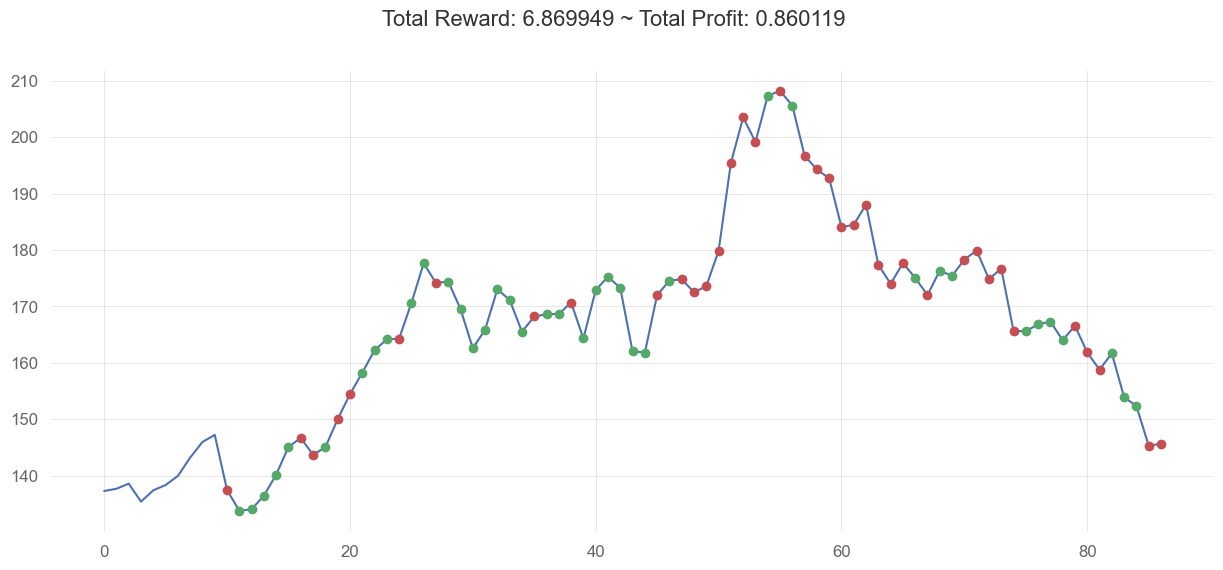

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

# 5. QuantStats

                           Strategy
-------------------------  ----------
Start Period               2024-01-04
End Period                 2024-04-22
Risk-Free Rate             0.0%
Time in Market             19.0%

Cumulative Return          -13.99%
CAGR﹪                     -29.42%

Sharpe                     -1.47
Prob. Sharpe Ratio         19.37%
Smart Sharpe               -1.45
Sortino                    -1.74
Smart Sortino              -1.73
Sortino/√2                 -1.23
Smart Sortino/√2           -1.22
Omega                      0.54

Max Drawdown               -24.02%
Longest DD Days            76
Volatility (ann.)          31.14%
Calmar                     -1.22
Skew                       -2.11
Kurtosis                   19.19

Expected Daily %           -0.2%
Expected Monthly %         -3.7%
Expected Yearly %          -13.99%
Kelly Criterion            -30.56%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.41%
Expected Shortfall (cVaR)  -3.41%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-02-07,2024-04-19,2024-04-22,75,-24.020557,-14.171493


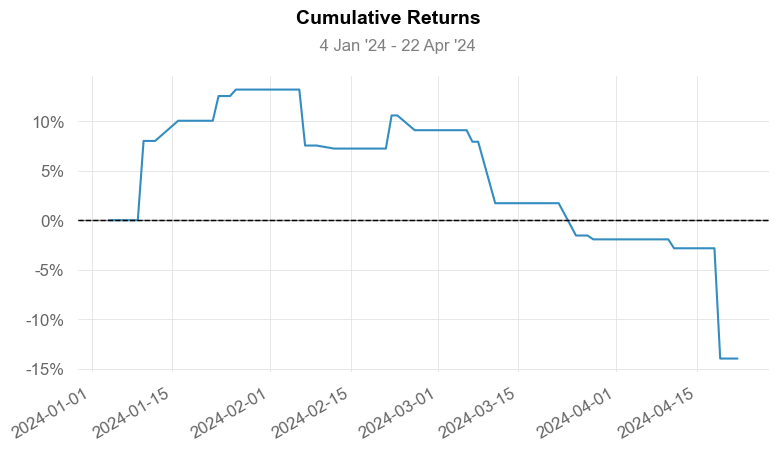

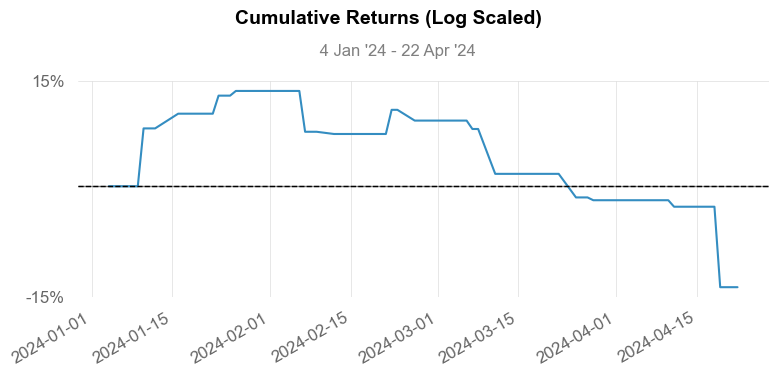

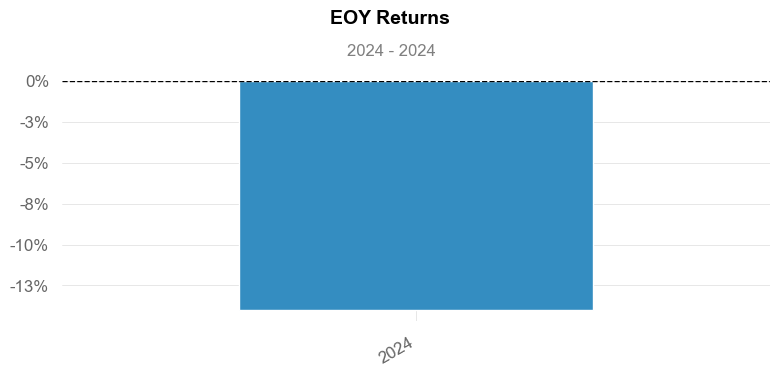

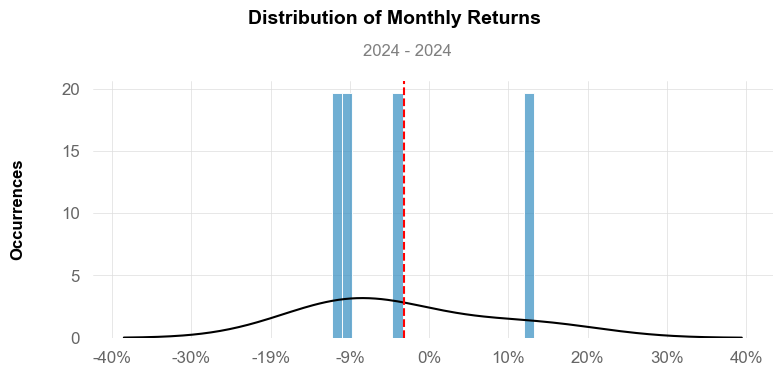

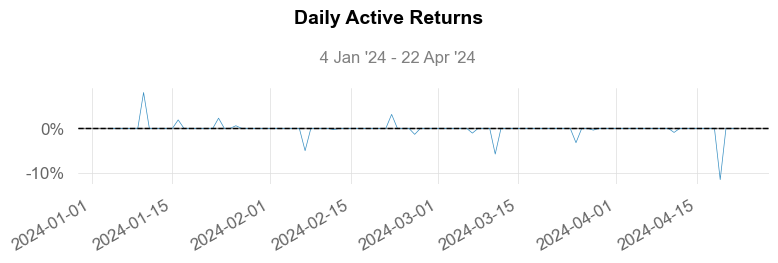

IndexError: index 0 is out of bounds for axis 0 with size 0

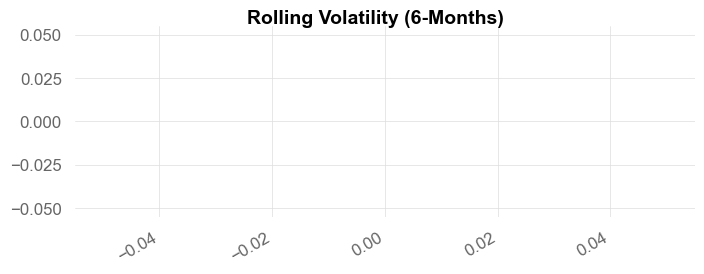

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[TEST_ENV_FRAME_BOUND[0] + 1:TEST_ENV_FRAME_BOUND[1]])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

In [ ]:
qs.reports.html(returns, output="quantstats-amd.html")

c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\supha\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 